In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from prettytable import PrettyTable
from tabulate import tabulate

from sklearn.linear_model import LogisticRegression, SGDClassifier       # LR
from sklearn.neighbors import KNeighborsClassifier                       # kNN
from sklearn.tree import DecisionTreeClassifier                          # DT
from sklearn.ensemble import RandomForestClassifier                      # RF
from xgboost import XGBClassifier                                        # XGB

In [2]:
path = '/Users/tristangarcia/desktop/Network Traffic Classification/data/final/'

# Loading files
x_train = pd.read_pickle(f'{path}pcatrain.pkl')
y_train = pd.read_pickle(f'{path}ytrain.pkl')

x_test = pd.read_pickle(f'{path}pcavalidate.pkl')
y_test = pd.read_pickle(f'{path}yvalidate.pkl')

In [3]:
results = {'model':[], 'accuracy':[], 'f1':[], 'far':[], 'auc':[]}

def add_model_results(model_name, accuracy, auc, f1, far):
    results['model'].append(model_name)
    results['accuracy'].append(accuracy)
    results['f1'].append(f1)
    results['far'].append(far)
    results['auc'].append(auc)


# Utility Functions

In [4]:
def false_alarm_rate(y_true, y_pred):
    '''
    - returns the average of FPR and FNR
    - to be used as a scorer for CV
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FPR = fp / (fp + tn)
    FNR = fn / (fn + tp)
    
    return round(((FPR + FNR) / 2), 4)


def calculate_auc_f1(y_true, y_pred):
    """
    Calculate AUC and F1-Score for the given true and predicted values.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_value = round(auc(fpr, tpr), 4)
    f1 = round(f1_score(y_true, y_pred), 4)
    return auc_value, f1, fpr, tpr


def print_results_table(train_results, test_results, model_name):
    """
    Print results in a PrettyTable for train and test datasets, now including accuracy.
    """
    x = PrettyTable()
    x.field_names = ['Dataset', 'Model', 'Accuracy', 'AUC', 'F1-score', 'FAR']
    
    # Unpack train and test results
    train_accuracy, train_auc, train_f1, train_far = train_results
    test_accuracy, test_auc, test_f1, test_far = test_results
    
    x.add_row(['Train', model_name, train_accuracy, train_auc, train_f1, train_far])
    x.add_row(['Test', model_name, test_accuracy, test_auc, test_f1, test_far])
    print(x)
    
    
def plot_auc_curves(train_fpr, train_tpr, test_fpr, test_tpr, train_auc, test_auc):
    """
    Plot AUC curves for train and test datasets.
    """
    plt.figure()
    plt.plot(train_fpr, train_tpr, label=f"Train AUC: {train_auc}")
    plt.plot(test_fpr, test_tpr, label=f"Test AUC: {test_auc}")
    plt.grid()
    plt.legend()
    plt.show()
    
    
def plot_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred, labels):
    """
    Plot confusion matrices for both train and test datasets.
    """
    train_cmap=sns.light_palette("green")
    test_cmap=sns.light_palette("blue")
    
    plt.figure(figsize=(16,5))
    
    # Train confusion matrix
    plt.subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, cmap=train_cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Train Confusion Matrix")
    
    # Test confusion matrix
    plt.subplot(1,2,2)
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, cmap=test_cmap, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Test Confusion Matrix")
    
    plt.show()
    
    
def evaluate_model(model, x_train, y_train, x_test, y_test, model_name):
    """ 
    Evaluate model performance on train and test data, using smaller helper functions.
    """
    # Train the model
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    # Calculate metrics for train set
    train_far = false_alarm_rate(y_train, y_train_pred)
    train_auc, train_f1, train_fpr_curve, train_tpr_curve = calculate_auc_f1(y_train, y_train_pred)
    train_accuracy = round(accuracy_score(y_train, y_train_pred), 4)
    
    # Calculate metrics for test set
    test_far = false_alarm_rate(y_test, y_test_pred)
    test_auc, test_f1, test_fpr_curve, test_tpr_curve = calculate_auc_f1(y_test, y_test_pred)
    test_accuracy = round(accuracy_score(y_test, y_test_pred), 4)
    
    # Print results in a table
    train_results = (train_accuracy, train_auc, train_f1, train_far)
    test_results = (test_accuracy, test_auc, test_f1, test_far)
    print_results_table(train_results, test_results, model_name)
    
    # Plot confusion matrices
    plot_confusion_matrices(y_train, y_train_pred, y_test, y_test_pred, labels=['normal', 'attack'])
    
    # Plot AUC curves
    plot_auc_curves(train_fpr_curve, train_tpr_curve, test_fpr_curve, test_tpr_curve, train_auc, test_auc)
    
    # Adding Results to Results dictionary
    add_model_results(model_name, test_accuracy, test_auc, test_f1, test_far)


In [5]:
def hyperparameter_tune(clf, param_grid, x, y):
    '''
    Perform hyperparameter tuning with
    - 5 fold stratified cross validation
    - multiple scoring functions
    - recorded total time
    '''
    # CrossValidation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    
    # Multiple scoring functions
    scoring = {
        'auc': 'roc_auc',
        'f1': 'f1',
        'FAR': make_scorer(false_alarm_rate, greater_is_better=False)
    }
    s_time = time.time()    # Starting time
    
    # GridSearch
    tuned_model = GridSearchCV(clf, param_grid=param_grid, scoring=scoring, refit='f1', 
                               cv=cv, verbose=1, return_train_score=True, n_jobs=-1)
    tuned_model.fit(x,y)
    
    e_time = time.time()    # End time
    print(f'Total time taken: {(e_time - s_time):.2f} seconds')

    # Output the results
    print(f"Best params: {tuned_model.best_params_}")
    print(f"Best estimator: {tuned_model.best_estimator_}")
    print(f"Best score: {tuned_model.best_score_}")
    
    return tuned_model


In [6]:
def plot_search_results(tuned_model):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = tuned_model.cv_results_
    means_test = results['mean_test_f1']
    stds_test = results['std_test_f1']
    means_train = results['mean_train_f1']
    stds_train = results['std_train_f1']

    params=tuned_model.param_grid
    p = list(params.keys())

    
    if len(params) > 2:
        # https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
        ## Getting indexes of values per hyper-parameter
        masks=[]
        masks_names= list(tuned_model.best_params_.keys())
        for p_k, p_v in tuned_model.best_params_.items():
            masks.append(list(results['param_'+p_k].data==p_v))
        ## Ploting results
        fig, ax = plt.subplots(1,len(params), sharex='none', sharey='all', figsize=(20,5))
        fig.suptitle('Score per parameter')
        fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
        pram_preformace_in_best = {}

        for i, p in enumerate(masks_names):
            m = np.stack(masks[:i] + masks[i+1:])
            pram_preformace_in_best
            best_parms_mask = m.all(axis=0)
            best_index = np.where(best_parms_mask)[0]

            x = np.array(params[p])
            y_1 = np.array(means_test[best_index])
            e_1 = np.array(stds_test[best_index])
            y_2 = np.array(means_train[best_index])
            e_2 = np.array(stds_train[best_index])

            ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
            ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
            ax[i].set_xlabel(p.upper())

        plt.legend()
        plt.show()
    
    # Heatmap if there are two variables
    elif len(params) == 2:
        # Heatmap
        train_cmap=sns.light_palette("green")
        test_cmap=sns.light_palette("blue")
        
        # Figure and axis
        fig = plt.figure(figsize=(20,5))
        train_ax = fig.add_subplot(1,2,1)
        test_ax = fig.add_subplot(1,2,2)
        
        # train heatmap
        sns.heatmap(means_train.reshape(len(params[p[0]]), len(params[p[1]])),
                    cmap=train_cmap, annot=True, fmt='.4f', ax=train_ax,
                    xticklabels=params[p[1]], yticklabels=params[p[0]]);
        
        # test heapmap
        sns.heatmap(means_test.reshape(len(params[p[0]]), len(params[p[1]])),
                    cmap=test_cmap, annot=True, fmt='.4f', ax=test_ax,
                    xticklabels=params[p[1]], yticklabels=params[p[0]]);
        
        # axis labels and plot title
        train_ax.set_title("Train Hyperparameter Heatmap")
        train_ax.set_xlabel(p[1])
        train_ax.set_ylabel(p[0])

        test_ax.set_title("Test Hyperparameter Heatmap")
        test_ax.set_xlabel(p[1])
        test_ax.set_ylabel(p[0])
        plt.show()
    
    # Plotting a line plot if there is only one variable
    elif len(params) == 1:
        plt.figure(figsize=(10,5))
        plt.plot(params[p[0]], means_train, label="train")
        plt.plot(params[p[0]], means_test, label="test")

        # Plot for train data
        for i, txt in enumerate(means_train):
            plt.annotate((params[p[0]][i], np.round(txt, 3)), (params[p[0]][i], means_train[i]))
        
        # Plot for test data
        for i, txt in enumerate(means_test):
            plt.annotate((params[p[0]][i], np.round(txt, 3)), (params[p[0]][i], means_test[i]))
        
        plt.xlabel(p[0])
        plt.ylabel('f1')
        plt.grid()
        plt.legend()
        plt.show()


# Logistic Regression

In [7]:
lr = SGDClassifier(loss='log_loss')
param = {
    'alpha':np.logspace(-8, 1, 10), 
    'penalty':['l1','l2']
}

tuned_model = hyperparameter_tune(lr, param, x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Total time taken: 97.42 seconds
Best params: {'alpha': 0.001, 'penalty': 'l1'}
Best estimator: SGDClassifier(alpha=0.001, loss='log_loss', penalty='l1')
Best score: 0.9370483156947051


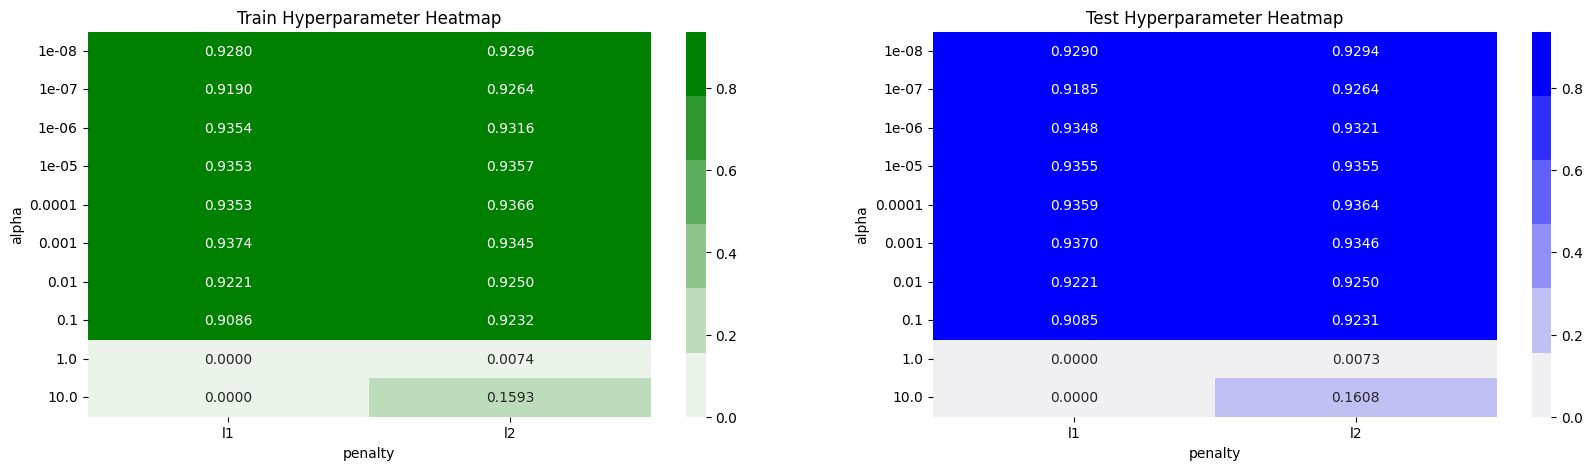

In [8]:
plot_search_results(tuned_model)

+---------+-------+----------+--------+----------+--------+
| Dataset | Model | Accuracy |  AUC   | F1-score |  FAR   |
+---------+-------+----------+--------+----------+--------+
|  Train  |   LR  |  0.9728  | 0.964  |  0.9339  | 0.036  |
|   Test  |   LR  |  0.9728  | 0.9642 |  0.9337  | 0.0358 |
+---------+-------+----------+--------+----------+--------+


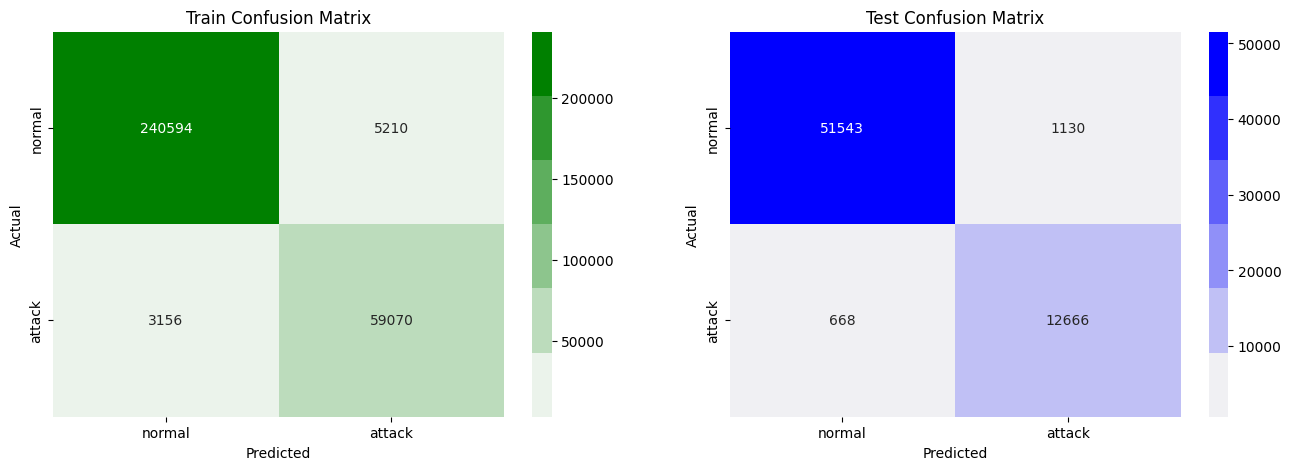

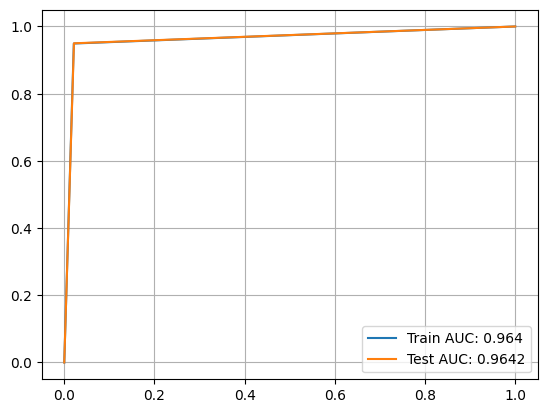

In [9]:
best_lr = tuned_model.best_estimator_
evaluate_model(best_lr, x_train, y_train, x_test, y_test, 'LR')

In [10]:
results

{'model': ['LR'],
 'accuracy': [0.9728],
 'f1': [0.9337],
 'far': [0.0358],
 'auc': [0.9642]}

# Support Vector Classifier

In [11]:
svc = SGDClassifier(loss='hinge')
param = {
    'alpha':np.logspace(-8, 1, 10), 
    'penalty':['l1','l2']
}

tuned_model = hyperparameter_tune(svc, param, x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Total time taken: 99.27 seconds
Best params: {'alpha': 0.0001, 'penalty': 'l2'}
Best estimator: SGDClassifier()
Best score: 0.9443240817378034


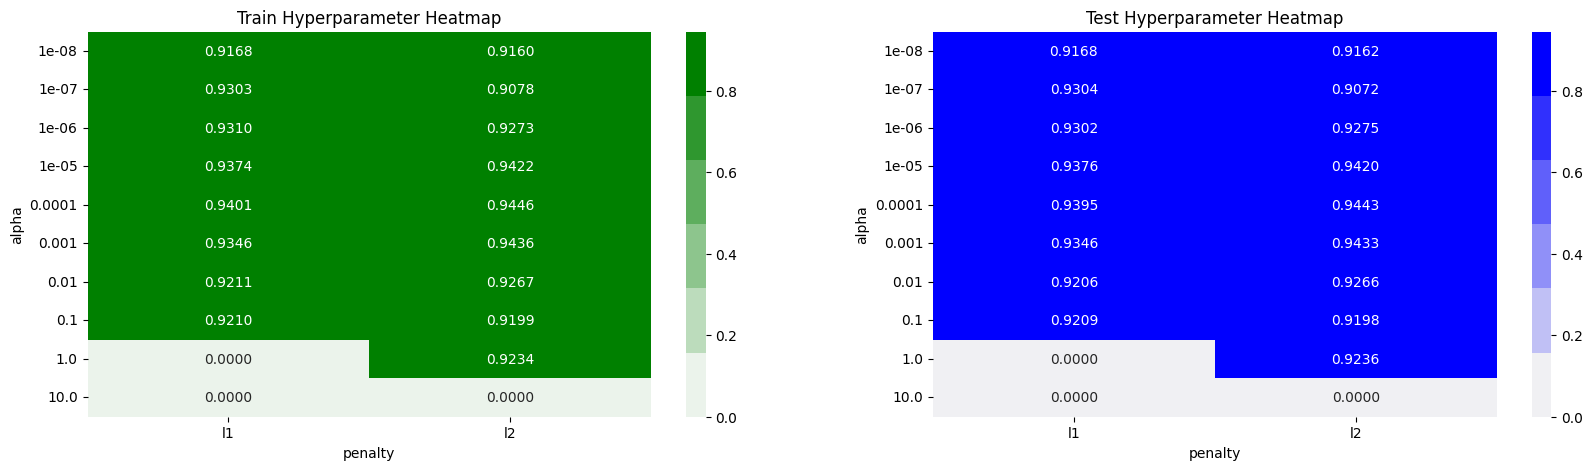

In [12]:
plot_search_results(tuned_model)

+---------+-------+----------+--------+----------+--------+
| Dataset | Model | Accuracy |  AUC   | F1-score |  FAR   |
+---------+-------+----------+--------+----------+--------+
|  Train  |  SVC  |  0.9769  | 0.9789 |  0.9449  | 0.0211 |
|   Test  |  SVC  |  0.9768  | 0.9796 |  0.9448  | 0.0204 |
+---------+-------+----------+--------+----------+--------+


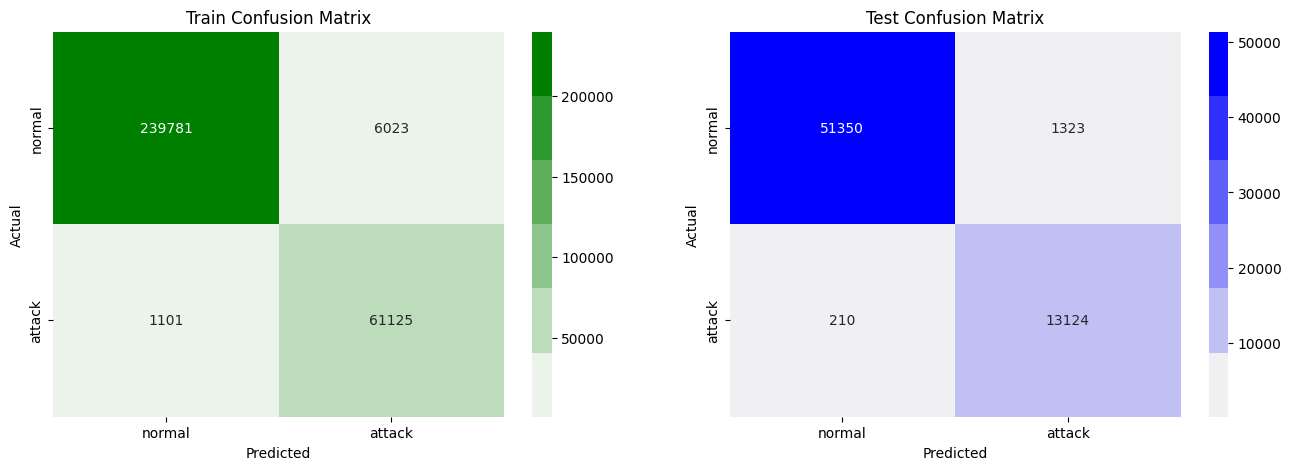

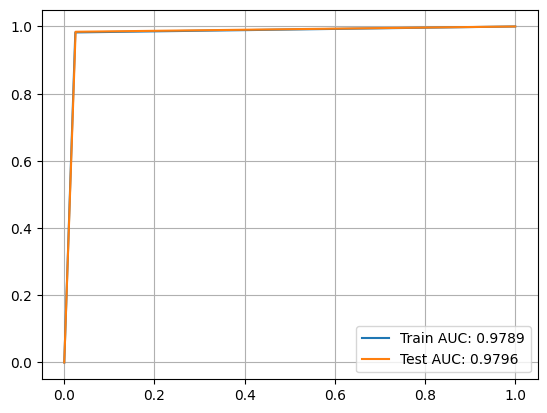

In [13]:
best_svc = tuned_model.best_estimator_
evaluate_model(best_svc, x_train, y_train, x_test, y_test, 'SVC')

In [14]:
results

{'model': ['LR', 'SVC'],
 'accuracy': [0.9728, 0.9768],
 'f1': [0.9337, 0.9448],
 'far': [0.0358, 0.0204],
 'auc': [0.9642, 0.9796]}

# Decision Tree

In [15]:
dt = DecisionTreeClassifier()
param = {
    'max_depth':[4, 6, 8, 10, 20],
    'min_samples_split':[2, 5, 10, 20, 40],
    'min_samples_leaf':[1, 2, 4, 8]
}

tuned_model = hyperparameter_tune(dt, param, x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Total time taken: 1200.15 seconds
Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best estimator: DecisionTreeClassifier(max_depth=20)
Best score: 0.9721253370731808


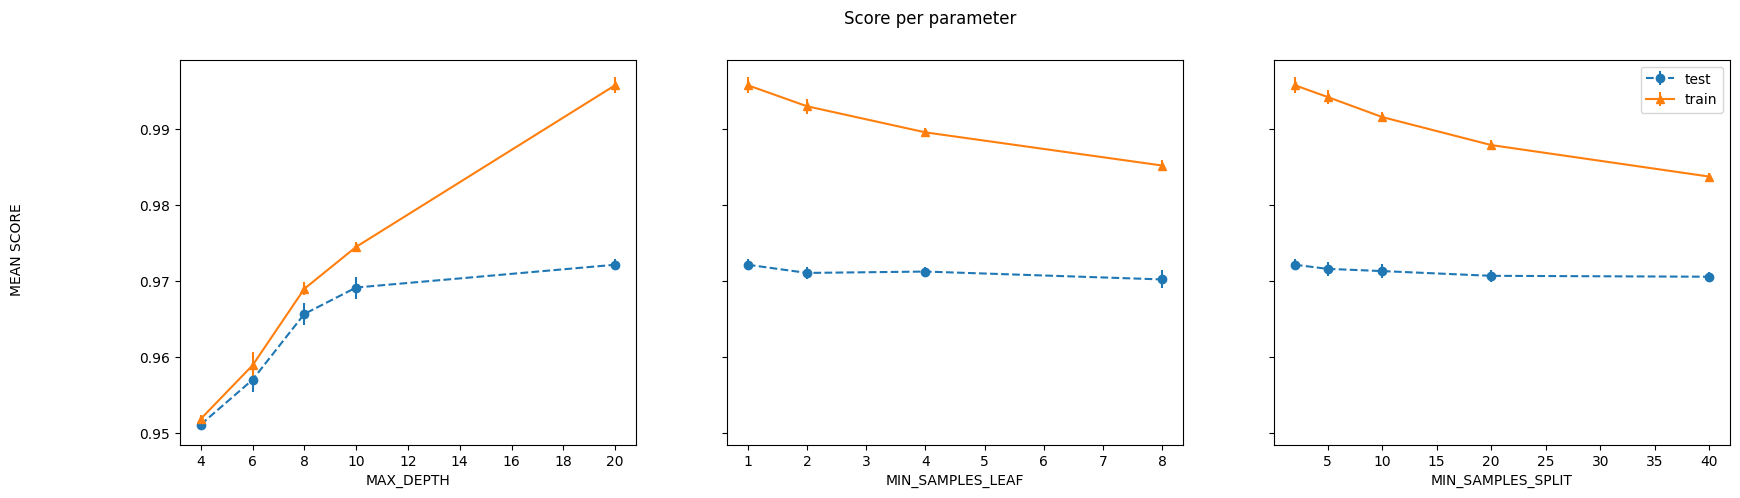

In [16]:
plot_search_results(tuned_model)

+---------+-------+----------+--------+----------+--------+
| Dataset | Model | Accuracy |  AUC   | F1-score |  FAR   |
+---------+-------+----------+--------+----------+--------+
|  Train  |   DT  |  0.9981  | 0.997  |  0.9954  | 0.003  |
|   Test  |   DT  |  0.9882  | 0.9806 |  0.9707  | 0.0194 |
+---------+-------+----------+--------+----------+--------+


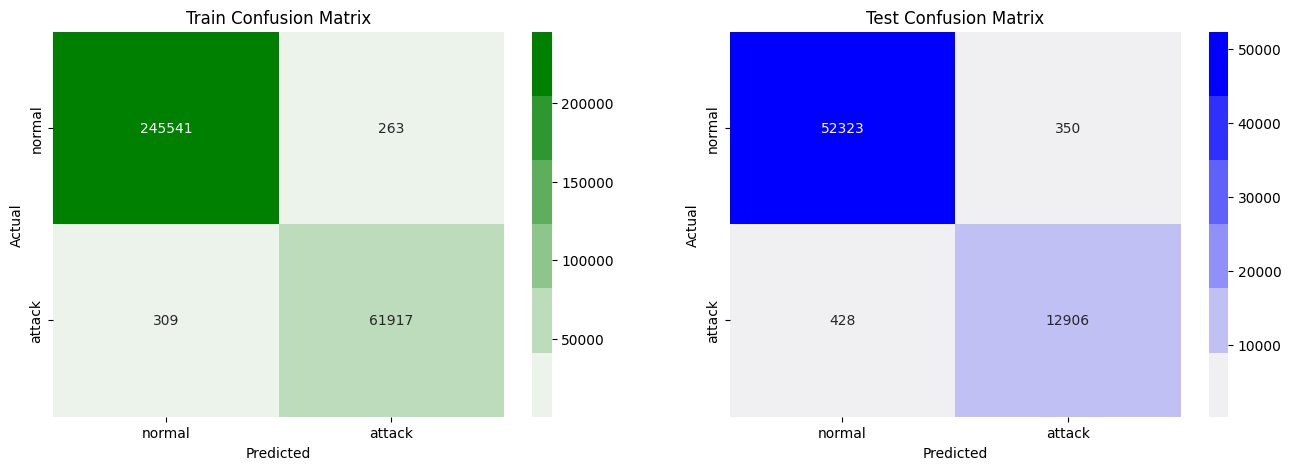

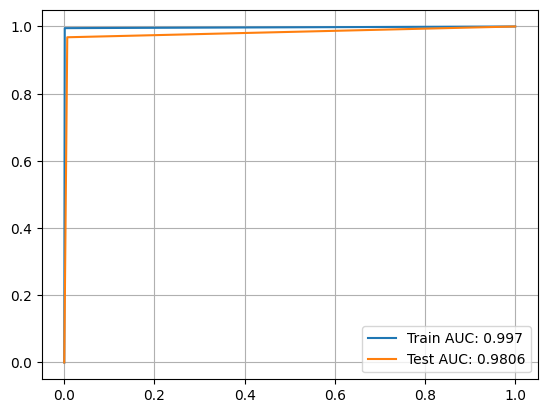

In [17]:
best_dt = tuned_model.best_estimator_
evaluate_model(best_dt, x_train, y_train, x_test, y_test, 'DT')

In [18]:
results

{'model': ['LR', 'SVC', 'DT'],
 'accuracy': [0.9728, 0.9768, 0.9882],
 'f1': [0.9337, 0.9448, 0.9707],
 'far': [0.0358, 0.0204, 0.0194],
 'auc': [0.9642, 0.9796, 0.9806]}

# XGBoost
https://datascience.stackexchange.com/questions/108233/recommendations-for-tuning-xgboost-hyperparams

In [19]:
xgb = XGBClassifier()
param = {
    'max_depth':[4,8,16,32],
    'min_child_weight':[1,10,20,40]
}

tuned_model = hyperparameter_tune(xgb, param, x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Total time taken: 188.55 seconds
Best params: {'max_depth': 32, 'min_child_weight': 1}
Best estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Best score: 0.9791121754892689


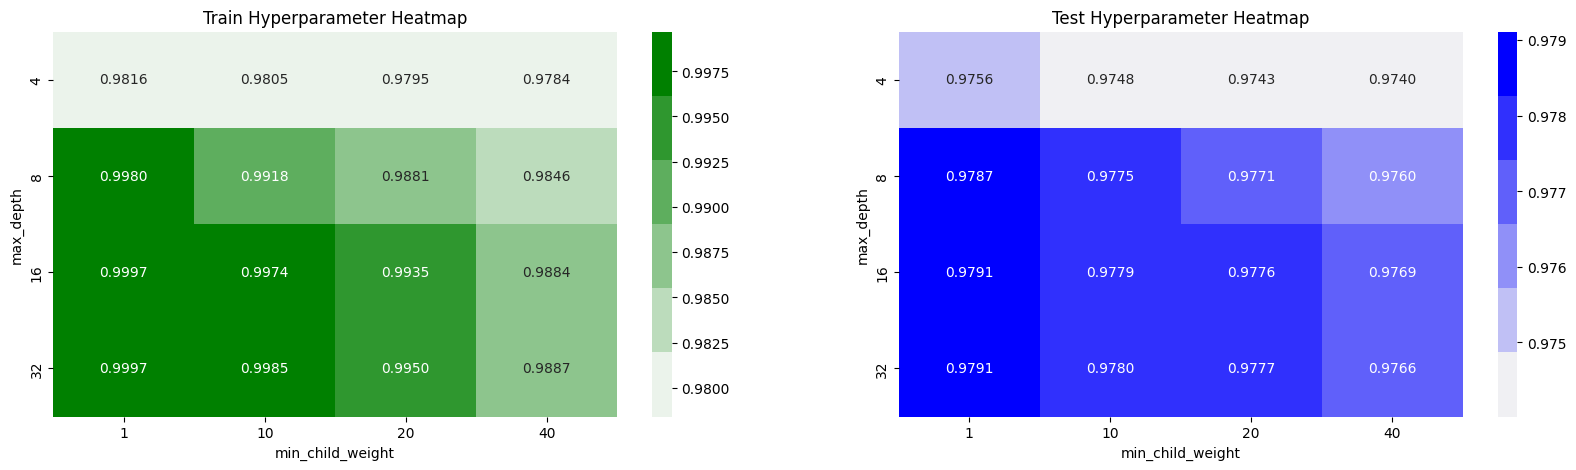

In [20]:
plot_search_results(tuned_model)

In [21]:
xgb = tuned_model.best_estimator_
param = {
    'subsample':[0.1,0.4,0.7,1],
    'colsample_bytree':[0.1,0.4,0.7,1]
}

tuned_model = hyperparameter_tune(xgb, param, x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Total time taken: 261.92 seconds
Best params: {'colsample_bytree': 1, 'subsample': 1}
Best estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Best score: 0.9791121754892689


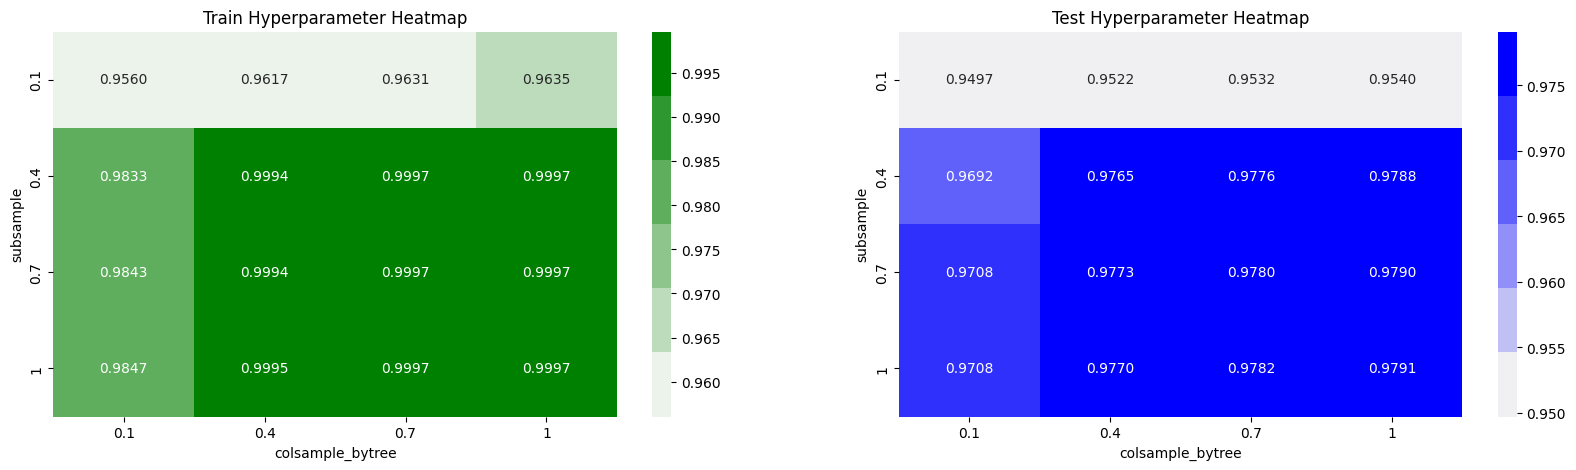

In [22]:
plot_search_results(tuned_model)

In [23]:
xgb = tuned_model.best_estimator_
param = {
    'n_estimators':[50,100,200,400,800]
}

tuned_model = hyperparameter_tune(xgb, param, x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Total time taken: 246.61 seconds
Best params: {'n_estimators': 100}
Best estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Best score: 0.9791121754892689


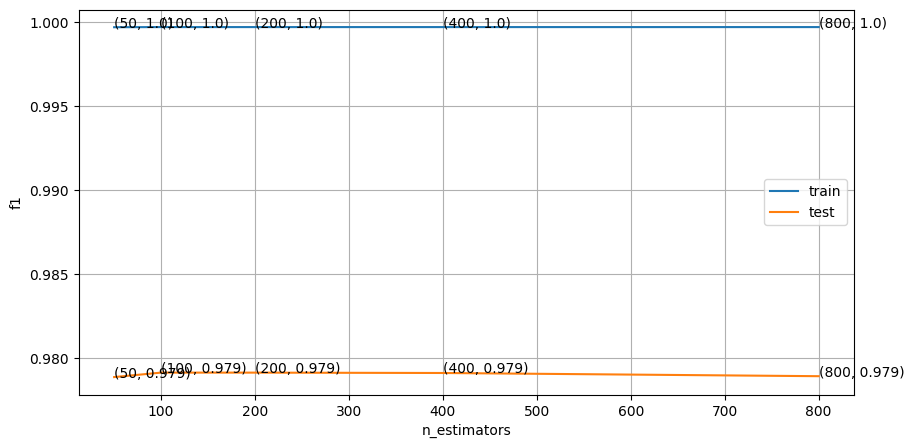

In [24]:
plot_search_results(tuned_model)

+---------+-------+----------+--------+----------+--------+
| Dataset | Model | Accuracy |  AUC   | F1-score |  FAR   |
+---------+-------+----------+--------+----------+--------+
|  Train  |  XGB  |  0.9999  | 0.9998 |  0.9997  | 0.0002 |
|   Test  |  XGB  |  0.9911  | 0.9864 |  0.978   | 0.0136 |
+---------+-------+----------+--------+----------+--------+


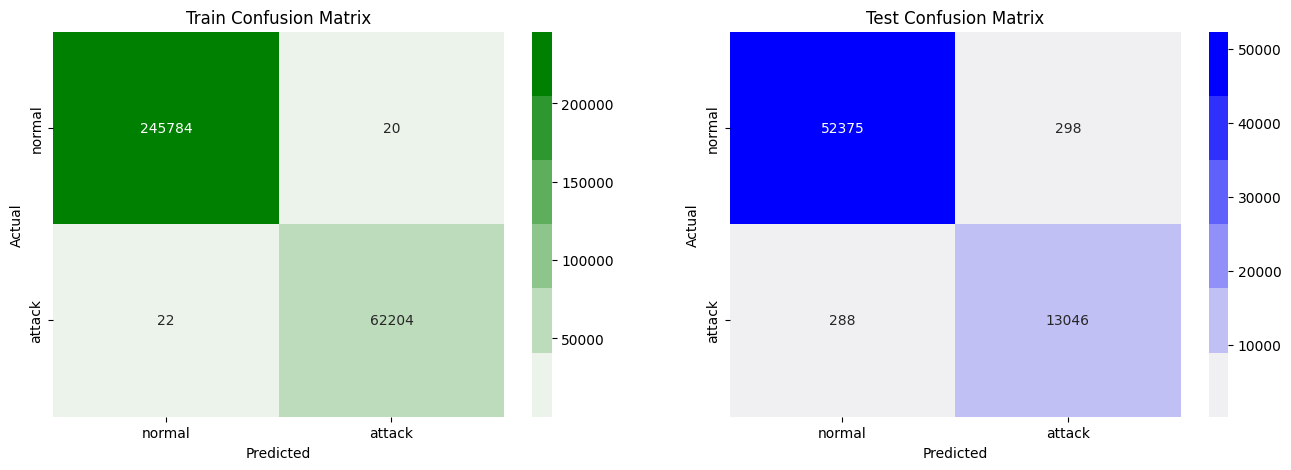

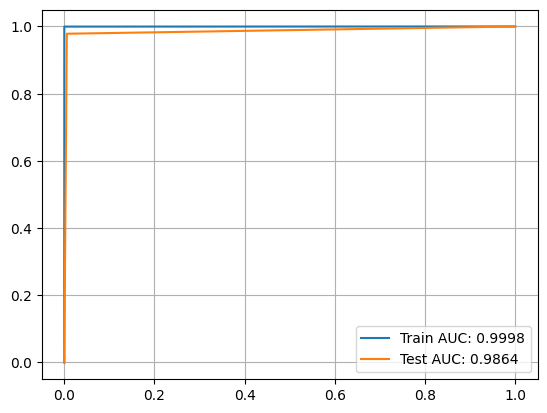

In [25]:
best_xgb = xgb = tuned_model.best_estimator_
evaluate_model(best_xgb, x_train, y_train, x_test, y_test, 'XGB')

In [26]:
results

{'model': ['LR', 'SVC', 'DT', 'XGB'],
 'accuracy': [0.9728, 0.9768, 0.9882, 0.9911],
 'f1': [0.9337, 0.9448, 0.9707, 0.978],
 'far': [0.0358, 0.0204, 0.0194, 0.0136],
 'auc': [0.9642, 0.9796, 0.9806, 0.9864]}

# Results Table

In [27]:
results = pd.DataFrame(results)
print(tabulate(results, headers='keys'))

    model      accuracy      f1     far     auc
--  -------  ----------  ------  ------  ------
 0  LR           0.9728  0.9337  0.0358  0.9642
 1  SVC          0.9768  0.9448  0.0204  0.9796
 2  DT           0.9882  0.9707  0.0194  0.9806
 3  XGB          0.9911  0.978   0.0136  0.9864
